# Link prediction with GCN

In this notebook we will perform a drug-drug interaction prediction using the Graph Convolutional Network algorithm for binary classification. The model will get as input node pairs of interactions and it will predict whether it exists an interaction or not. 

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.acolab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1


from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

## Data Loading

In [4]:
path = 'drive/My Drive/Data Intensive Computing/' # Blanca's
#path = 'drive/My Drive/KTH/Courses/Data Intensive Computing/' # Amrita's

In [5]:
# load edges
edges = pd.read_csv(path+'dataset_new/edges.csv')
edges = edges.drop(['drug_A_id', 'drugbank_id'],axis=1)
edges = edges.rename(columns={"drug_A_node_id": "source", "drug_B_node_id": "target"})
edges = edges.dropna()
edges = edges.astype({'source': 'int'})
edges.head(5)

,source,target
0,10315,9529
1,4259,9529
2,61,9529
3,1026,3685
4,6146,1028


In [6]:
# load features
node_features = pd.read_csv(path+'dataset_new/node_features.csv', index_col='node_id')
node_features = node_features.dropna(subset=['type'])
node_features = node_features.drop(['drug_id','type','group','interactions'],axis=1)

node_features

,is_biotech,is_small_molecule,withdrawn,illicit,vet_approved,investigational,approved,experimental,nutraceutical
node_id,,,,,,,,,
9529,True,False,False,False,False,False,True,False,False
3685,True,False,False,False,False,False,True,False,False
2938,True,False,False,False,False,False,True,False,False
6476,True,False,False,False,False,False,True,False,False
1028,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...
2804,False,True,False,False,False,False,False,False,False
4256,False,True,False,False,False,False,True,False,False
3018,True,False,False,False,False,False,False,False,False


In [7]:
# graph creation
graph = StellarGraph(nodes=node_features, edges=edges, node_type_default="drug", edge_type_default="interaction")

In [8]:
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 13580, Edges: 2668170

 Node types:
  drug: [13580]
    Features: float32 vector, length 9
    Edge types: drug-interaction->drug

 Edge types:
    drug-interaction->drug: [2668170]
        Weights: all 1 (default)
        Features: none


## Data Splitting

In [9]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.01 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True)

print(graph_test.info())

** Sampled 266817 positive and 266817 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 13580, Edges: 2401353

 Node types:
  drug: [13580]
    Features: float32 vector, length 9
    Edge types: drug-interaction->drug

 Edge types:
    drug-interaction->drug: [2401353]
        Weights: all 1 (default)
        Features: none


In [10]:
# Do the same process to compute a training subset from within the test graph
# EdgeSplitter takes in graph_test as graph to sample edges from and graph as original datasets.
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples_train, labels_train= edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

edge_splitter_val = EdgeSplitter(graph_train, graph)
graph_val, examples_val, labels_val= edge_splitter_val.train_test_split(
    p=0.1, method="global", keep_connected=True
)



** Sampled 240135 positive and 240135 negative edges. **
** Sampled 216121 positive and 216121 negative edges. **


In [11]:
print(graph_train.info())
print(graph_val.info())

StellarGraph: Undirected multigraph
 Nodes: 13580, Edges: 2161218

 Node types:
  drug: [13580]
    Features: float32 vector, length 9
    Edge types: drug-interaction->drug

 Edge types:
    drug-interaction->drug: [2161218]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 13580, Edges: 1945097

 Node types:
  drug: [13580]
    Features: float32 vector, length 9
    Edge types: drug-interaction->drug

 Edge types:
    drug-interaction->drug: [1945097]
        Weights: all 1 (default)
        Features: none


## GCN link prediction

In [14]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [12]:
epochs = 500

In [15]:
# create train, val and test flows for model
train_gen = FullBatchLinkGenerator(graph_train, method="gcn")
train_flow = train_gen.flow(examples_train, labels_train)

val_gen = FullBatchLinkGenerator(graph_val, method="gcn") 
val_flow = val_gen.flow(examples_val, labels_val)

test_gen = FullBatchLinkGenerator(graph_test, method="gcn")
test_flow = test_gen.flow(examples_test, labels_test)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


In [93]:
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3)
x_inp, x_out = gcn.in_out_tensors()
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy","mean_squared_error"],
)

In [94]:
# initial (untrained) model on the train and test set

init_train_metrics = model.evaluate(train_flow)
init_val_metrics = model.evaluate(val_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nVal Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 0.8183 - binary_accuracy: 0.4258 - mean_squared_error: 0.3043

Train Set Metrics of the initial (untrained) model:
	loss: 0.8189
	binary_accuracy: 0.4250
	mean_squared_error: 0.3045

Val Set Metrics of the initial (untrained) model:
	loss: 0.8183
	binary_accuracy: 0.4258
	mean_squared_error: 0.3043


In [95]:
history = model.fit(train_flow, epochs=epochs, validation_data=val_flow, verbose=2, shuffle=False)

Epoch 1/500
1/1 - 0s - loss: 1.7729 - binary_accuracy: 0.3564 - mean_squared_error: 0.4877 - val_loss: 0.7289 - val_binary_accuracy: 0.5009 - val_mean_squared_error: 0.2678
Epoch 2/500
1/1 - 0s - loss: 1.4686 - binary_accuracy: 0.3945 - mean_squared_error: 0.3959 - val_loss: 0.6728 - val_binary_accuracy: 0.5225 - val_mean_squared_error: 0.2457
Epoch 3/500
1/1 - 0s - loss: 1.1832 - binary_accuracy: 0.4178 - mean_squared_error: 0.3399 - val_loss: 0.6475 - val_binary_accuracy: 0.5314 - val_mean_squared_error: 0.2381
Epoch 4/500
1/1 - 0s - loss: 0.9481 - binary_accuracy: 0.4547 - mean_squared_error: 0.2944 - val_loss: 0.5945 - val_binary_accuracy: 0.5633 - val_mean_squared_error: 0.2175
Epoch 5/500
1/1 - 0s - loss: 0.7858 - binary_accuracy: 0.5193 - mean_squared_error: 0.2535 - val_loss: 0.5655 - val_binary_accuracy: 0.5819 - val_mean_squared_error: 0.2068
Epoch 6/500
1/1 - 0s - loss: 0.6990 - binary_accuracy: 0.5440 - mean_squared_error: 0.2367 - val_loss: 0.5139 - val_binary_accuracy: 0.

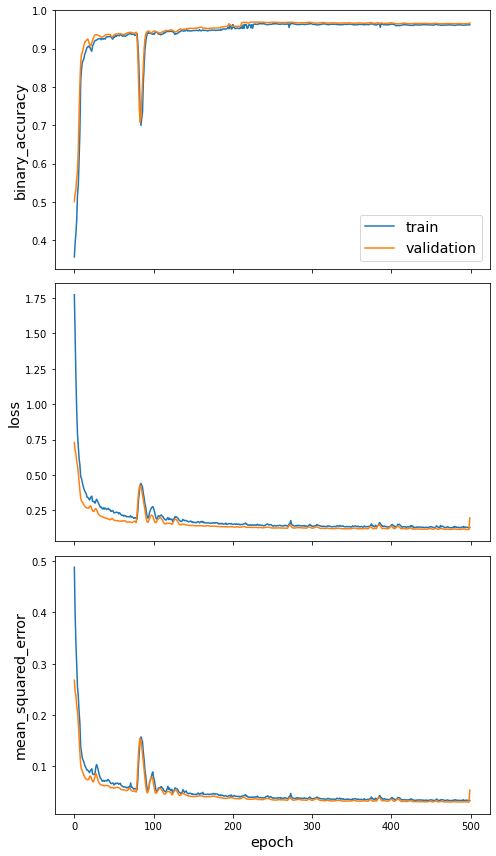

In [99]:
# plot training history 
sg.utils.plot_history(history)

In [97]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nVal Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 0.1969 - binary_accuracy: 0.9675 - mean_squared_error: 0.0539

Train Set Metrics of the trained model:
	loss: 0.1968
	binary_accuracy: 0.9677
	mean_squared_error: 0.0539

Val Set Metrics of the trained model:
	loss: 0.1969
	binary_accuracy: 0.9675
	mean_squared_error: 0.0539


In [98]:
test_metrics = model.evaluate(test_flow)

1/1 [==============================] - 0s 1ms/step - loss: 0.1964 - binary_accuracy: 0.9672 - mean_squared_error: 0.0537
